# Synchronised one-pulse signal generation and acquisition
Now that we are familiar with generating and acquiring signals with Red Pitaya, we can finally learn a few tricks for combining both and use them in practice. In this example, the acquisition is triggered together with the generation, which is used for measuring cable length and other applications where signal propagation delay is important.

**Note:**  
The voltage range of fast analog inputs on the Red Pitaya depends on the input jumper position. HV sets the input range to ±20 V, while LV sets the input range to ±1 V. For more information, please read the following [chapter](https://redpitaya.readthedocs.io/en/latest/developerGuide/hardware/125-14/fastIO.html#analog-inputs).

As previously, create a loop-back from fast analog outputs to fast analog inputs, as shown in the picture below.  
Please make sure the jumpers are set to ±1 V (LV).

![Fast loop back](../img/FastIOLoopBack.png "Example of the fast loop back.")

## Libraries and FPGA image

In [11]:
import time
import numpy as np
from matplotlib import pyplot as plt
from rp_overlay import overlay
import rp

fpga = overlay()
rp.rp_Init()

Check FPGA [OK].


0

## Marcos
Throughout this tutorial we will mention macros multiple times. Here is a complete list of macros that will come in handy when customising this notebook. The marcos are a part of the **rp** library.

**GENERATION**

- **Waveforms** - RP_WAVEFORM_SINE, RP_WAVEFORM_SQUARE, RP_WAVEFORM_TRIANGLE, RP_WAVEFORM_RAMP_UP, RP_WAVEFORM_RAMP_DOWN, RP_WAVEFORM_DC, RP_WAVEFORM_PWM, RP_WAVEFORM_ARBITRARY, RP_WAVEFORM_DC_NEG, RP_WAVEFORM_SWEEP
- **Generator modes** - RP_GEN_MODE_CONTINUOUS, RP_GEN_MODE_BURST
- **Sweep direction** - RP_GEN_SWEEP_DIR_NORMAL, RP_GEN_SWEEP_DIR_UP_DOWN
- **Sweep mode** - RP_GEN_SWEEP_MODE_LINEAR, RP_GEN_SWEEP_MODE_LOG
- **Generator trigger source** - RP_GEN_TRIG_SRC_INTERNAL, RP_GEN_TRIG_SRC_EXT_PE, RP_GEN_TRIG_SRC_EXT_NE
- **Generator triggers** - RP_T_CH_1, RP_T_CH_2, RP_T_CH_EXT
- **Rise and fall times** - RISE_FALL_MIN_RATIO, RISE_FALL_MAX_RATIO

**ACQUISITION**

- **Decimation** - RP_DEC_1, RP_DEC_2, RP_DEC_4, RP_DEC_8, RP_DEC_16, RP_DEC_32, RP_DEC_64, RP_DEC_128, RP_DEC_256, RP_DEC_512, RP_DEC_1024, RP_DEC_2048, RP_DEC_4096, RP_DEC_8192, RP_DEC_16384, RP_DEC_32768, RP_DEC_65536 
- **Acquisition trigger** - RP_TRIG_SRC_DISABLED, RP_TRIG_SRC_NOW, RP_TRIG_SRC_CHA_PE, RP_TRIG_SRC_CHA_NE, RP_TRIG_SRC_CHB_PE, RP_TRIG_SRC_CHB_NE, RP_TRIG_SRC_EXT_PE, RP_TRIG_SRC_EXT_NE, RP_TRIG_SRC_AWG_PE, RP_TRIG_SRC_AWG_NE
- **Acquisition trigger state** - RP_TRIG_STATE_TRIGGERED, RP_TRIG_STATE_WAITING
- **Buffer size** - ADC_BUFFER_SIZE, DAC_BUFFER_SIZE
- **Fast analog channels** - RP_CH_1, RP_CH_2

SIGNALlab 250-12 only:
- **Input coupling** - RP_DC, RP_AC
- **Generator gain** - RP_GAIN_1X, RP_GAIN_5X

STEMlab 125-14 4-Input only:
- **Fast analog channels** - RP_CH_3, RP_CH_4
- **Acquisition trigger** - RP_TRIG_SRC_CHC_PE, RP_TRIG_SRC_CHC_NE, RP_TRIG_SRC_CHD_PE, RP_TRIG_SRC_CHD_NE

## Synchronising generation and acquisition

The example itself is relatively trivial in comparison to others already presented during the tutorials. The only practical change is the **RP_TRIG_SOUR_AWG_PE**.

Parameters:

In [12]:
###### Generation #####
channel = rp.RP_CH_1        # rp.RP_CH_2
waveform = rp.RP_WAVEFORM_RAMP_UP
freq = 0.1164153218269348 * 2
ampl = 1.0

ncyc = 1
nor = 1
period = 10

gen_trig_sour = rp.RP_GEN_TRIG_SRC_INTERNAL

##### Acquisition #####
trig_lvl = 0.5
trig_dly = 0
dec = rp.RP_DEC_65536

acq_trig_sour = rp.RP_TRIG_SRC_AWG_PE

N = 32768 // 2

# Reset Generation and Acquisition
rp.rp_GenReset()
rp.rp_AcqReset()

0

Setting up both the generation and acquisition.

In [13]:
###### Generation #####
print("Gen_start")
rp.rp_GenWaveform(channel, waveform)
rp.rp_GenFreqDirect(channel, freq)
rp.rp_GenAmp(channel, ampl)

# Change to burst mode
rp.rp_GenMode(channel, rp.RP_GEN_MODE_BURST)
rp.rp_GenBurstCount(channel, ncyc)                  # Ncyc
rp.rp_GenBurstRepetitions(channel, nor)             # Nor
rp.rp_GenBurstPeriod(channel, period)               # Period


# Specify generator trigger source
rp.rp_GenTriggerSource(channel, gen_trig_sour)

# Enable output synchronisation
rp.rp_GenOutEnableSync(True)


##### Acquisition #####
# Set Decimation
rp.rp_AcqSetDecimation(dec)
rp.rp_AcqSetAveraging(True)
rp.rp_AcqSetGain(rp.RP_CH_1, rp.RP_HIGH)

# Set trigger level and delay
rp.rp_AcqSetTriggerLevel(rp.RP_T_CH_1, trig_lvl)
rp.rp_AcqSetTriggerDelay(trig_dly)


Gen_start


0

Starting acquisition and capturing data.

Acq_start
Trigger state: 0
Fill state: False


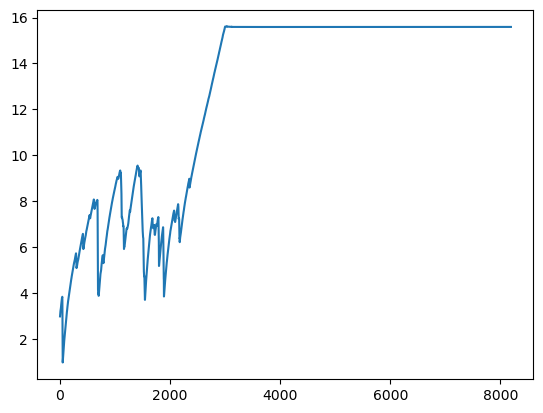

In [28]:
# Start Acquisition
print("Acq_start")
rp.rp_AcqStart()

# Specify trigger - input 1 positive edge
rp.rp_AcqSetTriggerSrc(acq_trig_sour)

time.sleep(5)

rp.rp_GenTriggerOnly(channel)       # Trigger generator

print(f"Trigger state: {rp.rp_AcqGetTriggerState()[1]}")

# Trigger state
while 1:
    trig_state = rp.rp_AcqGetTriggerState()[1]
    if trig_state == rp.RP_TRIG_STATE_TRIGGERED:
        break

# Fill state
print(f"Fill state: {rp.rp_AcqGetBufferFillState()[1]}")

while 1:
    if rp.rp_AcqGetBufferFillState()[1]:
        break


### Get data ###
# Volts
fbuff = rp.fBuffer(N)
res = rp.rp_AcqGetOldestDataV(rp.RP_CH_1, N, fbuff)[1]

data_V = np.zeros(N // 2, dtype = float)

for i in range(0, N // 2, 1):
    data_V[i] = fbuff[i + N // 2]

plt.plot(data_V)
plt.show()

In [10]:
# Release resources
rp.rp_Release()

0

One of the applications for this example is to measure how many samples are taken from the triggering moment to the start of the captured pulse, which corresponds to propagation delay on the transmission line.

### Note
There are a lot of different commands for the Acquisition. The list of available functions is quite an achievement to read through, so from now on, please refer to the *C and Python API section* of the [SCPI & API command list](https://redpitaya.readthedocs.io/en/latest/appsFeatures/remoteControl/command_list.html#list-of-supported-scpi-api-commands) for all available commands.
